<a href="https://www.kaggle.com/code/mrrogueknight/dynamic-pricing-for-urban-parking-lots?scriptVersionId=248848086" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [84]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/capstoneproject/dataset.csv


# Dynamic Pricing for Urban Parking Lots 
---
Summer Analytics 2025

##  What's the Problem?

- Urban areas often face a parking crisis.
- Some parking lots are always overcrowded
- while others remain empty, even when nearby.
---
Why? 
- Because parking prices are static i.e. they don’t change based on
- How full a lot is
- How heavy the traffic is
- What type of vehicle is trying to enter
- Or if it’s a holiday/event day
---

## What’s the Goal?

- building an AI-powered dynamic pricing system that updates parking fees in real time for each of 14 parking lots so that:
- Prices increase when demand is high
- Prices drop to attract drivers when demand is low
- The system learns from real-world patterns

## What Does “Dynamic Pricing” Mean?

Like how Uber or airline tickets go up in peak hours, you’ll build a system where:
- Prices adjust every 30 minutes
- Based on real-time data (occupancy, traffic, etc.)
- Starting from a base price example of $10
This makes parking smarter, fairer, and better utilized.

## Visualization

We will use Bokeh to create real-time visualizations 
- Show how price changes per lot over time
- Compare prices between nearby parking lots

## Real-Time Simulation Using Pathway

Instead of reading data all at once, we'll simulate how data arrives in real time:

- One row at a time (like streaming data)
- Pricing must update as each new row comes in
- Pathway helps manage this simulation

## Library Imports

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh.plotting as bp
from bokeh.io import output_notebook, show
output_notebook()

# Optional
import seaborn as sns

Loading BokehJS ...

## Data Loading & Exploration

In [86]:
df = pd.read_csv('/kaggle/input/capstoneproject/dataset.csv')

In [87]:
print(df.shape)

(18368, 12)


In [88]:
df.head()

,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18368 entries, 0 to 18367
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      18368 non-null  int64  
 1   SystemCodeNumber        18368 non-null  object 
 2   Capacity                18368 non-null  int64  
 3   Latitude                18368 non-null  float64
 4   Longitude               18368 non-null  float64
 5   Occupancy               18368 non-null  int64  
 6   VehicleType             18368 non-null  object 
 7   TrafficConditionNearby  18368 non-null  object 
 8   QueueLength             18368 non-null  int64  
 9   IsSpecialDay            18368 non-null  int64  
 10  LastUpdatedDate         18368 non-null  object 
 11  LastUpdatedTime         18368 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 1.7+ MB


In [90]:
df.describe()

,ID,Capacity,Latitude,Longitude,Occupancy,QueueLength,IsSpecialDay
count,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000
mean,9183.500000,1605.214286,25.706547,90.751170,731.084059,4.587925,0.150915
std,5302.529208,1131.153886,1.582749,3.536636,621.164982,2.580062,0.357975
min,0.000000,387.000000,20.000035,78.000003,2.000000,0.000000,0.000000
25%,4591.750000,577.000000,26.140048,91.727995,322.000000,2.000000,0.000000
50%,9183.500000,1261.000000,26.147482,91.729511,568.000000,4.000000,0.000000
75%,13775.250000,2803.000000,26.147541,91.736172,976.000000,6.000000,0.000000
max,18367.000000,3883.000000,26.150504,91.740994,3499.000000,15.000000,1.000000


# Model 1: Baseline Linear Model

## Formula:

$$
\text{Price}_{t+1} = \text{Price}_t + \alpha \times \left(\frac{\text{Occupancy}}{\text{Capacity}}\right)
$$

* Start with **Price = \$10**
* Use a fixed **α (alpha)** value (e.g., `0.3`) - Stable pricing for brand trust
* Ensure the price stays within reasonable bounds (e.g., `$5 to $20`)
* Calculate price **per lot**, sorted in time

In [91]:
# Combine date and time to create a timestamp
df['Timestamp'] = pd.to_datetime(
    df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],
    format='%d-%m-%Y %H:%M:%S'
)

In [92]:
# Sort data by parking lot and time
df_sorted = df.sort_values(by=['SystemCodeNumber', 'Timestamp']).copy()

In [93]:
df_sorted

,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime,Timestamp
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00,2016-10-04 07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00,2016-10-04 08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00,2016-10-04 08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00,2016-10-04 09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00,2016-10-04 09:59:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18363,18363,Shopping,1920,26.150504,91.733531,1517,truck,average,6,0,19-12-2016,14:30:00,2016-12-19 14:30:00
18364,18364,Shopping,1920,26.150504,91.733531,1487,car,low,3,0,19-12-2016,15:03:00,2016-12-19 15:03:00
18365,18365,Shopping,1920,26.150504,91.733531,1432,cycle,low,3,0,19-12-2016,15:29:00,2016-12-19 15:29:00
18366,18366,Shopping,1920,26.150504,91.733531,1321,car,low,2,0,19-12-2016,16:03:00,2016-12-19 16:03:00


In [94]:
# Set pricing parameters
alpha = 0.3 # slow, stable, profit-friendly
base_price = 10.0
min_price = 5.0
max_price = 20.0

In [95]:
# Apply pricing logic per parking lot
baseline_prices = []

In [96]:
for lot_id, lot_data in df_sorted.groupby('SystemCodeNumber'):
    price = base_price
    lot_prices = []

    for _, row in lot_data.iterrows():
        occupancy_ratio = row['Occupancy'] / row['Capacity']
        price += alpha * occupancy_ratio
        price = max(min_price, min(price, max_price))
        lot_prices.append(price)

    baseline_prices.extend(lot_prices)

In [97]:
# Add BaselinePrice to your dataframe
df_sorted['BaselinePrice'] = baseline_prices

In [98]:
# Step 6: Preview the results
df_sorted[['SystemCodeNumber', 'Timestamp', 'Occupancy', 'Capacity', 'BaselinePrice']].head(10)

,SystemCodeNumber,Timestamp,Occupancy,Capacity,BaselinePrice
0,BHMBCCMKT01,2016-10-04 07:59:00,61,577,10.031716
1,BHMBCCMKT01,2016-10-04 08:25:00,64,577,10.064991
2,BHMBCCMKT01,2016-10-04 08:59:00,80,577,10.106586
3,BHMBCCMKT01,2016-10-04 09:32:00,107,577,10.162218
4,BHMBCCMKT01,2016-10-04 09:59:00,150,577,10.240208
5,BHMBCCMKT01,2016-10-04 10:26:00,177,577,10.332236
6,BHMBCCMKT01,2016-10-04 10:59:00,219,577,10.446101
7,BHMBCCMKT01,2016-10-04 11:25:00,247,577,10.574523
8,BHMBCCMKT01,2016-10-04 11:59:00,259,577,10.709185
9,BHMBCCMKT01,2016-10-04 12:29:00,266,577,10.847487


In [99]:
# Filter for a single parking lot
first_lot = df_sorted['SystemCodeNumber'].unique()[0]
df_lot = df_sorted[df_sorted['SystemCodeNumber'] == first_lot]

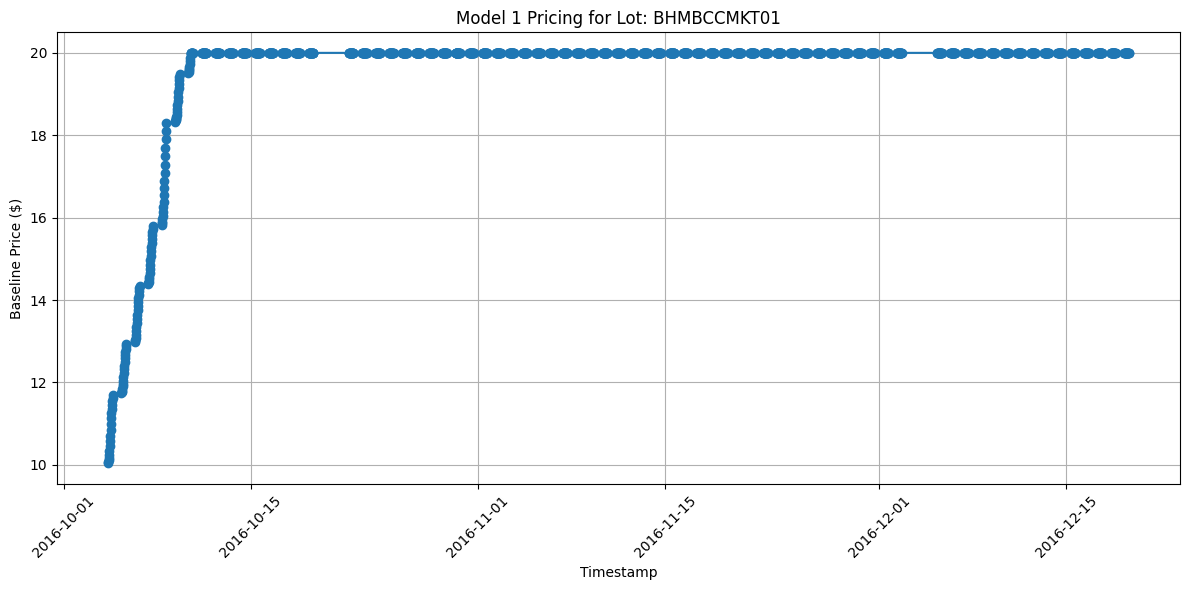

In [100]:
# Plot price over time
plt.figure(figsize=(12, 6))
plt.plot(df_lot['Timestamp'], df_lot['BaselinePrice'], marker='o', linestyle='-')
plt.title(f"Model 1 Pricing for Lot: {first_lot}")
plt.xlabel("Timestamp")
plt.ylabel("Baseline Price ($)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Bokeh

In [101]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.layouts import layout

In [102]:
output_notebook()

Loading BokehJS ...

In [103]:
source = ColumnDataSource(df_lot)

In [104]:
p = figure(x_axis_type='datetime', title=f"Model 1 Pricing for Lot: {first_lot}",
           width=900, height=400)
p.line('Timestamp', 'BaselinePrice', source=source, line_width=2, color='navy', legend_label="Baseline Price")
p.scatter('Timestamp', 'BaselinePrice', source=source, size=5, color='red') 
# Changed circle() to scatter()

GlyphRenderer(id='p1414', ...)

In [105]:
# Style plot
p.xaxis.axis_label = 'Time'
p.yaxis.axis_label = 'Price ($)'
p.legend.location = 'top_left'
p.grid.grid_line_alpha = 0.3

In [106]:
show(p)

## Compare Pricing for Multiple Parking Lots

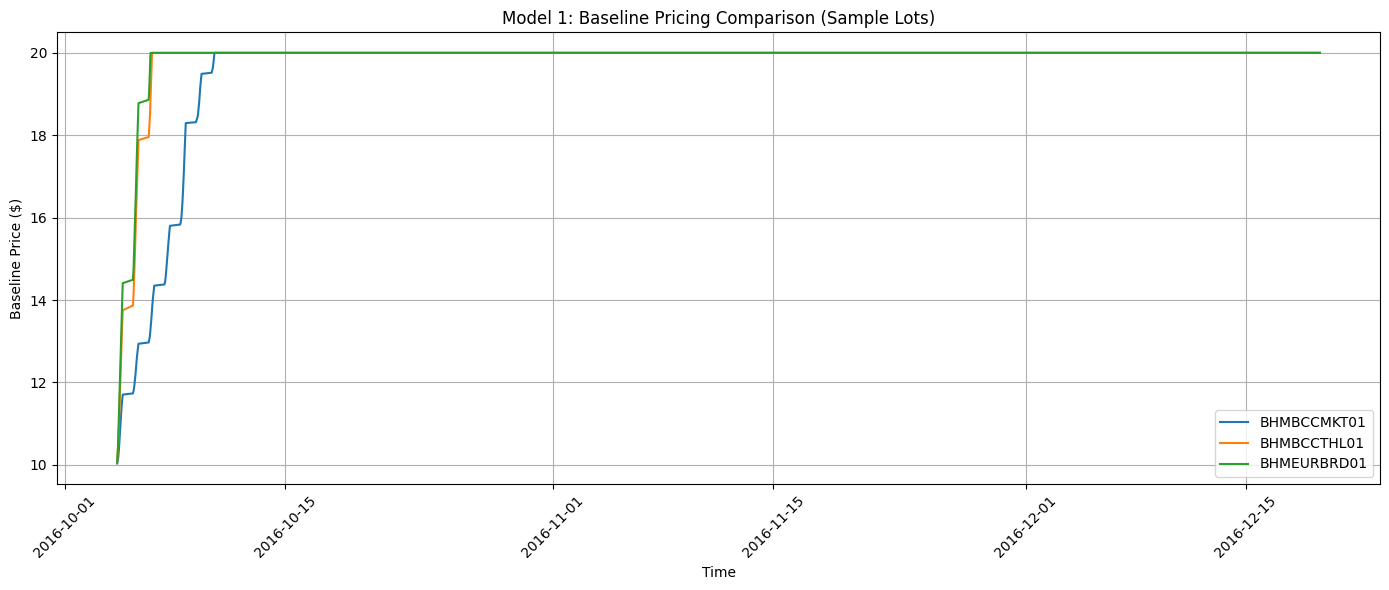

In [107]:
sample_lots = df_sorted['SystemCodeNumber'].unique()[:3]

plt.figure(figsize=(14, 6))

for lot in sample_lots:
    lot_data = df_sorted[df_sorted['SystemCodeNumber'] == lot]
    plt.plot(lot_data['Timestamp'], lot_data['BaselinePrice'], label=lot)

plt.title("Model 1: Baseline Pricing Comparison (Sample Lots)")
plt.xlabel("Time")
plt.ylabel("Baseline Price ($)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Estimate Revenue per Row

Since:

$$
\text{Revenue}_t = \text{Occupancy}_t \times \text{Price}_t
$$

We can add a `Revenue` column for each row using `BaselinePrice`.



In [108]:
# Calculate revenue per row
df_sorted['Revenue'] = df_sorted['Occupancy'] * df_sorted['BaselinePrice']

In [109]:
# Preview updated DataFrame
df_sorted[['SystemCodeNumber', 'Timestamp', 'Occupancy', 'BaselinePrice', 'Revenue']].head(10)

,SystemCodeNumber,Timestamp,Occupancy,BaselinePrice,Revenue
0,BHMBCCMKT01,2016-10-04 07:59:00,61,10.031716,611.934662
1,BHMBCCMKT01,2016-10-04 08:25:00,64,10.064991,644.159445
2,BHMBCCMKT01,2016-10-04 08:59:00,80,10.106586,808.526863
3,BHMBCCMKT01,2016-10-04 09:32:00,107,10.162218,1087.357366
4,BHMBCCMKT01,2016-10-04 09:59:00,150,10.240208,1536.031196
5,BHMBCCMKT01,2016-10-04 10:26:00,177,10.332236,1828.805719
6,BHMBCCMKT01,2016-10-04 10:59:00,219,10.446101,2287.696014
7,BHMBCCMKT01,2016-10-04 11:25:00,247,10.574523,2611.907279
8,BHMBCCMKT01,2016-10-04 11:59:00,259,10.709185,2773.679029
9,BHMBCCMKT01,2016-10-04 12:29:00,266,10.847487,2885.431542


In [110]:
# Select relevant columns
model1_output = df_sorted[['SystemCodeNumber', 'Timestamp', 'Occupancy', 'Capacity', 'BaselinePrice', 'Revenue']]

In [111]:
# Save to CSV
model1_output.to_csv("model1_Baseline_Linear_Model_pricing_output.csv", index=False)

# Summary Documentation Cell for Model 1

### Model 1: Baseline Linear Pricing

#### Objective:

To create a simple pricing model where the parking price increases **linearly** with **occupancy**, simulating basic economic behavior (high demand → higher price).

#### Formula:

$$
\text{Price}_{t+1} = \text{Price}_t + \alpha \times \left(\frac{\text{Occupancy}}{\text{Capacity}}\right)
$$

* **Base Price:** \$10.00
* **Alpha (α):** 0.3 *(slow and profit-focused)*
* **Clipping Range:** \$5.00 to \$20.00

  * Prevents unrealistic price surges or underpricing

---

#### Assumptions:

* Occupancy ratio directly reflects real-time demand.
* Price updates are **smooth and gradual** (not erratic).
* External features like traffic and queue are **not** used in this model (reserved for Model 2).
* Occupancy data is assumed to be accurate and synced in time.

---

#### Implementation Highlights:

* Prices are calculated **per lot** and **over time** using a rolling update.
* Price is clipped between \$5 and \$20 to maintain economic realism.
* Revenue is calculated as:

$$
\text{Revenue}_t = \text{BaselinePrice}_t \times \text{Occupancy}_t
$$

---

#### Outputs:

* Column: `BaselinePrice` — dynamically updated price
* Column: `Revenue` — estimated revenue at each time step
* Visualization: Price trend vs time (per lot)
* File: `model1_baseline_pricing_output.csv` — cleaned output

---

# Model 2: Demand-Based Pricing

## Objective

Create a smarter pricing model where the price responds to **demand signals**, using:

* Occupancy Rate
* Queue Length
* Traffic Conditions
* Special Day Indicator
* Vehicle Type

## Encoding Mappings

In [112]:
df['VehicleType'].unique()

array(['car', 'bike', 'truck', 'cycle'], dtype=object)

In [113]:
# VehicleType -> VehicleTypeWeight
vehicle_weights = {
    'bike': 0.5,
    'car': 1.0,
    'truck': 1.5,
    'cycle': 0.7  # for rare type
}

In [114]:
# TrafficConditionNearby -> TrafficLevel
traffic_levels = {
    'low': 0,
    'medium': 1,
    'high': 2,
    'average': 1  # to treat 'average' like 'medium'
}

In [115]:
# Made a copy to work on Model 2
df_model2 = df_sorted.copy()

In [116]:
df_model2['VehicleTypeWeight'] = df_model2['VehicleType'].map(vehicle_weights)
df_model2['TrafficLevel'] = df_model2['TrafficConditionNearby'].map(traffic_levels)

In [117]:
df_model2[['VehicleType', 'VehicleTypeWeight', 'TrafficConditionNearby', 'TrafficLevel']].head(10)

,VehicleType,VehicleTypeWeight,TrafficConditionNearby,TrafficLevel
0,car,1.0,low,0
1,car,1.0,low,0
2,car,1.0,low,0
3,car,1.0,low,0
4,bike,0.5,low,0
5,car,1.0,low,0
6,truck,1.5,high,2
7,car,1.0,average,1
8,cycle,0.7,average,1
9,bike,0.5,high,2


## Define Feature Weights & Calculate Demand

$$
\text{Demand}_t = \alpha \cdot \left(\frac{\text{Occupancy}}{\text{Capacity}}\right) + \beta \cdot \text{QueueLength} - \gamma \cdot \text{TrafficLevel} + \delta \cdot \text{IsSpecialDay} + \epsilon \cdot \text{VehicleTypeWeight}
$$

---

### Weights (We can tune these later):

| Feature         | Symbol | Suggested Value | Reason                                |
| --------------- | ------ | --------------- | ------------------------------------- |
| Occupancy Ratio | α      | `1.0`           | Core demand driver                    |
| Queue Length    | β      | `0.5`           | Extra waiting implies high demand     |
| Traffic Level   | γ      | `0.3`           | High traffic may reduce desirability  |
| Special Day     | δ      | `1.0`           | Demand spikes on events/holidays      |
| Vehicle Weight  | ε      | `0.2`           | Bigger vehicles = more valuable space |


In [118]:
# Define weights
alpha = 1.0
beta = 0.5
gamma = 0.3
delta = 1.0
epsilon = 0.2

In [119]:
# Compute occupancy ratio
df_model2['OccupancyRatio'] = df_model2['Occupancy'] / df_model2['Capacity']

In [120]:
# Calculate raw demand score
df_model2['RawDemand'] = (
    alpha   * df_model2['OccupancyRatio'] +
    beta    * df_model2['QueueLength'] -
    gamma   * df_model2['TrafficLevel'] +
    delta   * df_model2['IsSpecialDay'] +
    epsilon * df_model2['VehicleTypeWeight']
)

In [121]:
df_model2[['Occupancy', 'Capacity', 'OccupancyRatio', 'QueueLength', 'TrafficLevel',
           'IsSpecialDay', 'VehicleTypeWeight', 'RawDemand']].head(10)

,Occupancy,Capacity,OccupancyRatio,QueueLength,TrafficLevel,IsSpecialDay,VehicleTypeWeight,RawDemand
0,61,577,0.105719,1,0,0,1.0,0.805719
1,64,577,0.110919,1,0,0,1.0,0.810919
2,80,577,0.138648,2,0,0,1.0,1.338648
3,107,577,0.185442,2,0,0,1.0,1.385442
4,150,577,0.259965,2,0,0,0.5,1.359965
5,177,577,0.306759,3,0,0,1.0,2.006759
6,219,577,0.379549,6,2,0,1.5,3.079549
7,247,577,0.428076,5,1,0,1.0,2.828076
8,259,577,0.448873,5,1,0,0.7,2.788873
9,266,577,0.461005,8,2,0,0.5,3.961005


## Normalize Demand

We want to **scale `RawDemand` into a range between 0 and 1**, so that pricing remains:

* **Smooth** (no huge jumps)
* **Bounded** (doesn’t exceed 2x or go below 0.5x base price)

---

### Method: **Min-Max Normalization**

$$
\text{NormalizedDemand}_t = \frac{\text{RawDemand}_t - \text{Min}}{\text{Max} - \text{Min}}
$$

We'll then use it in:

$$
\text{Model2Price}_t = \text{BasePrice} \cdot (1 + \lambda \cdot \text{NormalizedDemand})
$$

---

In [122]:
raw_min = df_model2['RawDemand'].min()
raw_max = df_model2['RawDemand'].max()

In [123]:
df_model2['NormalizedDemand'] = (df_model2['RawDemand'] - raw_min) / (raw_max - raw_min)

In [124]:
# Preview
df_model2[['RawDemand', 'NormalizedDemand']].head(10)

,RawDemand,NormalizedDemand
0,0.805719,0.077414
1,0.810919,0.078000
2,1.338648,0.137496
3,1.385442,0.142772
4,1.359965,0.139900
5,2.006759,0.212819
6,3.079549,0.333766
7,2.828076,0.305415
8,2.788873,0.300995
9,3.961005,0.433142


### Compute Final Price Using Normalized Demand

We now apply the dynamic pricing formula:

$$
\text{Model2Price}_t = \text{BasePrice} \cdot (1 + \lambda \cdot \text{NormalizedDemand})
$$

---

In [125]:
#Final pricing
base_price = 10.0
lambda_ = 1.0  # sensitivity to normalized demand
min_price = 5.0
max_price = 20.0

In [126]:
# Compute price using normalized demand
df_model2['Model2Price'] = base_price * (1 + lambda_ * df_model2['NormalizedDemand'])

In [127]:
# Clip the price between min and max bounds
df_model2['Model2Price'] = df_model2['Model2Price'].clip(lower=min_price, upper=max_price)

In [128]:
# Preview result
df_model2[['NormalizedDemand', 'Model2Price']].head(10)

,NormalizedDemand,Model2Price
0,0.077414,10.774137
1,0.078000,10.779999
2,0.137496,11.374963
3,0.142772,11.427719
4,0.139900,11.398996
5,0.212819,12.128194
6,0.333766,13.337661
7,0.305415,13.054150
8,0.300995,13.009952
9,0.433142,14.331418


# Plotting Model2Price vs Model1Price Over Time

In [129]:
# Pick a sample parking lot
sample_lot = df_model2['SystemCodeNumber'].unique()[0]
lot_data = df_model2[df_model2['SystemCodeNumber'] == sample_lot]

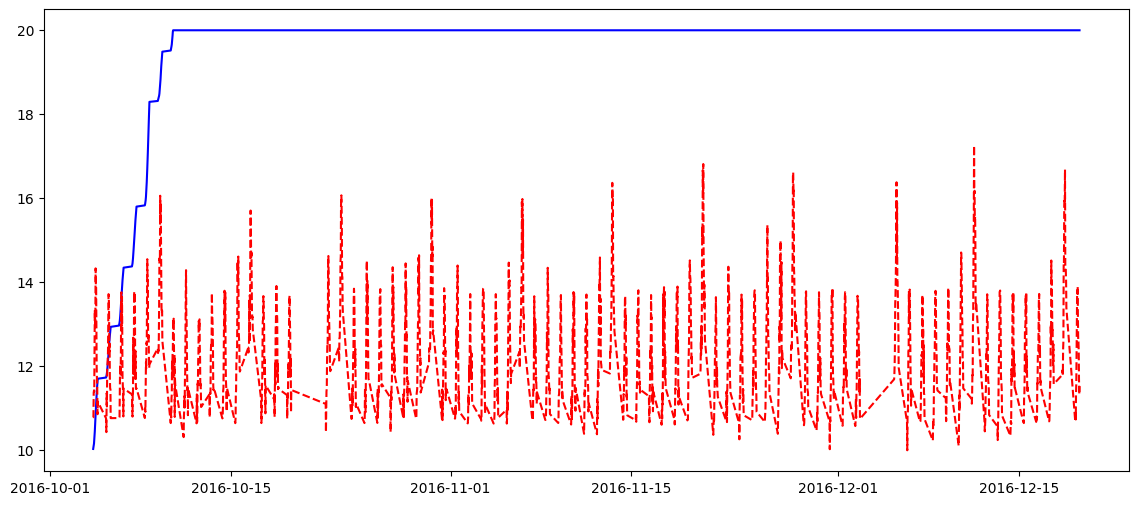

In [130]:
# Plot both models
plt.figure(figsize=(14, 6))
plt.plot(lot_data['Timestamp'], lot_data['BaselinePrice'], label='Model 1: Linear', color='blue')
plt.plot(lot_data['Timestamp'], lot_data['Model2Price'], label='Model 2: Demand-Based', color='red', linestyle='--')

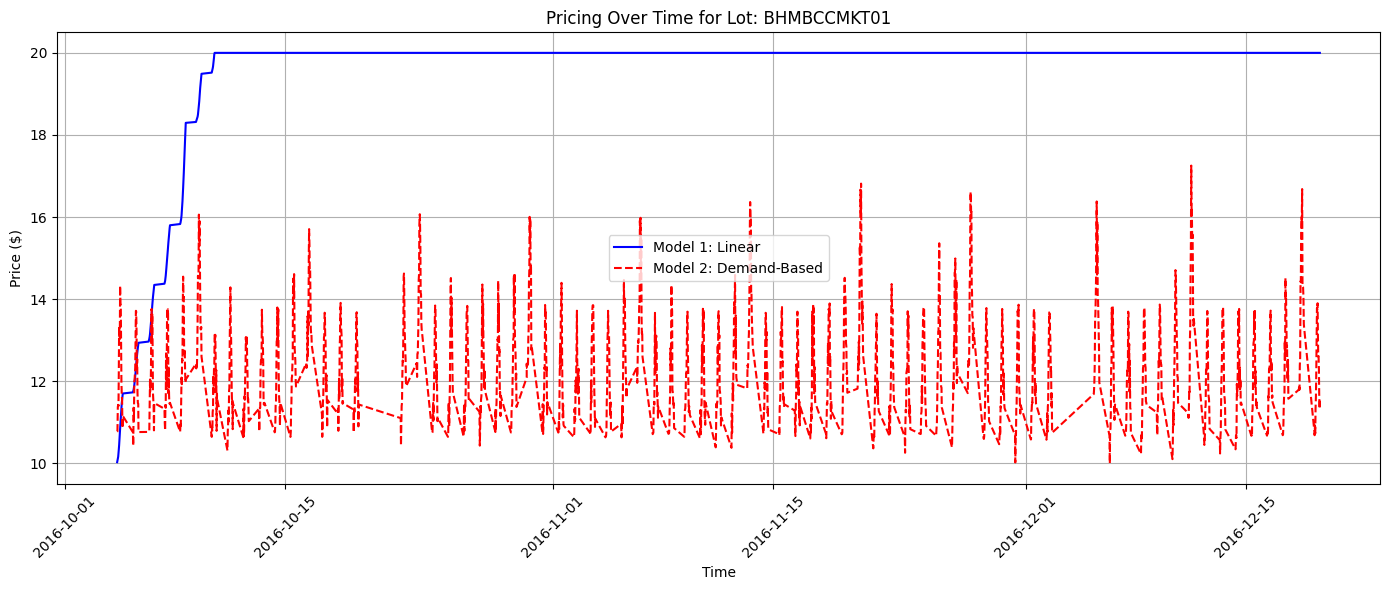

In [131]:
import matplotlib.pyplot as plt

sample_lot = df_model2['SystemCodeNumber'].unique()[0]
lot_data = df_model2[df_model2['SystemCodeNumber'] == sample_lot]

plt.figure(figsize=(14, 6))
plt.plot(lot_data['Timestamp'], lot_data['BaselinePrice'], label='Model 1: Linear', color='blue')
plt.plot(lot_data['Timestamp'], lot_data['Model2Price'], label='Model 2: Demand-Based', color='red', linestyle='--')

plt.title(f"Pricing Over Time for Lot: {sample_lot}")
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [132]:
# Step 1: Time-based features
df_model2['Hour'] = pd.to_datetime(df_model2['Timestamp']).dt.hour
df_model2['DayOfWeek'] = pd.to_datetime(df_model2['LastUpdatedDate'], format='%d-%m-%Y').dt.dayofweek

df_model2['IsOfficeHour'] = df_model2['Hour'].between(9, 17).astype(int)
df_model2['IsWeekend'] = df_model2['DayOfWeek'].isin([5, 6]).astype(int)

In [133]:
# New weights
zeta = 0.8  # weekend effect
eta = 0.6   # office hour effect

In [134]:
# Recompute raw demand with new terms
df_model2['RawDemand'] = (
    alpha   * df_model2['OccupancyRatio'] +
    beta    * df_model2['QueueLength'] -
    gamma   * df_model2['TrafficLevel'] +
    delta   * df_model2['IsSpecialDay'] +
    epsilon * df_model2['VehicleTypeWeight'] +
    zeta    * df_model2['IsWeekend'] +
    eta     * df_model2['IsOfficeHour']
)

In [135]:
# Normalize demand again
raw_min = df_model2['RawDemand'].min()
raw_max = df_model2['RawDemand'].max()
df_model2['NormalizedDemand'] = (df_model2['RawDemand'] - raw_min) / (raw_max - raw_min)


In [136]:
# Recalculate Model2Price
df_model2['Model2Price'] = base_price * (1 + lambda_ * df_model2['NormalizedDemand'])
df_model2['Model2Price'] = df_model2['Model2Price'].clip(lower=min_price, upper=max_price)

In [137]:
# Revenue for Model 2
df_model2['Model2Revenue'] = df_model2['Model2Price'] * df_model2['Occupancy']

In [138]:
# Preview
df_model2[['Timestamp', 'IsWeekend', 'IsOfficeHour', 'RawDemand', 'NormalizedDemand', 'Model2Price']].head()

,Timestamp,IsWeekend,IsOfficeHour,RawDemand,NormalizedDemand,Model2Price
0,2016-10-04 07:59:00,0,0,0.805719,0.072114,10.721141
1,2016-10-04 08:25:00,0,0,0.810919,0.072660,10.726602
2,2016-10-04 08:59:00,0,0,1.338648,0.128084,11.280836
3,2016-10-04 09:32:00,0,1,1.985442,0.196011,11.960114
4,2016-10-04 09:59:00,0,1,1.959965,0.193336,11.933358


In [139]:
# Backup
df_model2['Model2Price_PreEnhancement'] = df_model2['Model2Price']

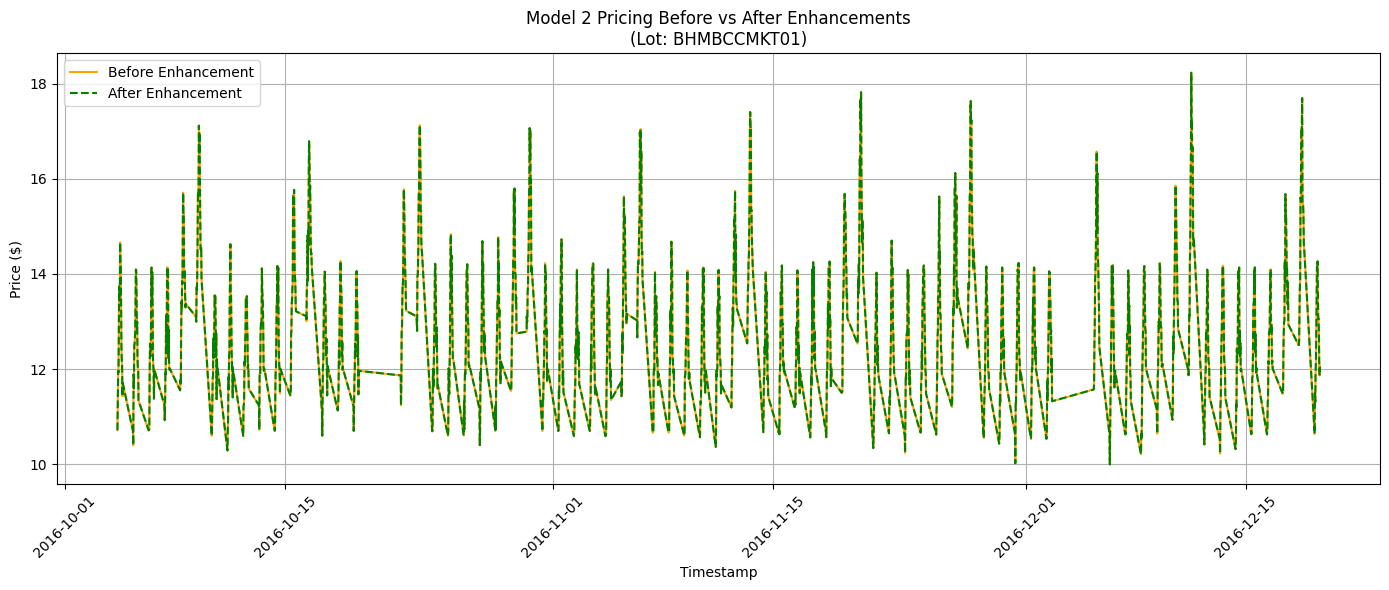

In [140]:
import matplotlib.pyplot as plt

# Pick a parking lot
sample_lot = df_model2['SystemCodeNumber'].unique()[0]
lot_data = df_model2[df_model2['SystemCodeNumber'] == sample_lot]

plt.figure(figsize=(14, 6))
plt.plot(lot_data['Timestamp'], lot_data['Model2Price_PreEnhancement'], label='Before Enhancement', color='orange')
plt.plot(lot_data['Timestamp'], lot_data['Model2Price'], label='After Enhancement', color='green', linestyle='--')

plt.title(f"Model 2 Pricing Before vs After Enhancements\n(Lot: {sample_lot})")
plt.xlabel("Timestamp")
plt.ylabel("Price ($)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_35/168888758.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(lot_data['Timestamp'], rotation=45)


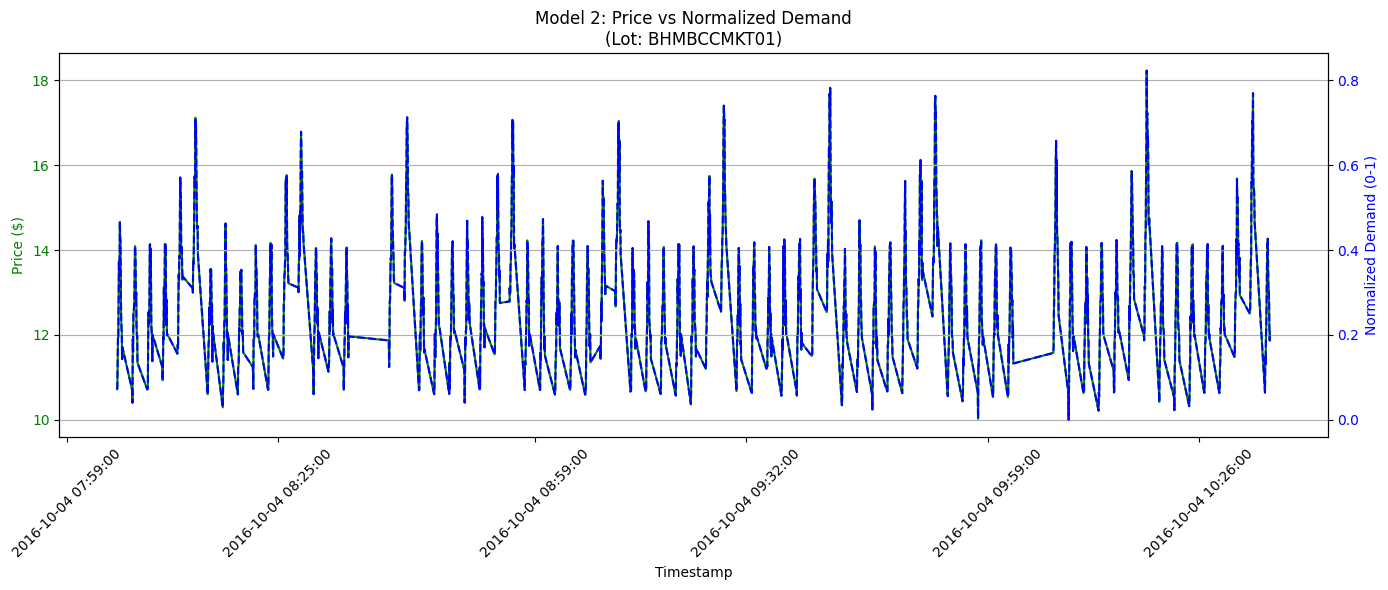

In [141]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# Price line
ax1.plot(lot_data['Timestamp'], lot_data['Model2Price'], color='green', label='Model2 Price')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Price ($)', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_xticklabels(lot_data['Timestamp'], rotation=45)

# Demand line on secondary axis
ax2 = ax1.twinx()
ax2.plot(lot_data['Timestamp'], lot_data['NormalizedDemand'], color='blue', linestyle='--', label='Normalized Demand')
ax2.set_ylabel('Normalized Demand (0-1)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Title and layout
plt.title(f"Model 2: Price vs Normalized Demand\n(Lot: {sample_lot})")
fig.tight_layout()
plt.grid(True)
plt.show()

In [142]:
# Choosen relevant output columns
model2_export = df_model2[[
    'SystemCodeNumber', 'Timestamp', 'Occupancy', 'Capacity',
    'QueueLength', 'TrafficConditionNearby', 'IsSpecialDay', 'VehicleType',
    'IsWeekend', 'IsOfficeHour', 'Model2Price', 'Model2Revenue'
]]

# Lets export to CSV
model2_export.to_csv("model2_Demand_Based_Price_Function_pricing_output.csv", index=False)

## Bokeh Plot: Model2Price + NormalizedDemand

In [143]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, LinearAxis, Range1d
from bokeh.layouts import column

output_notebook()

Loading BokehJS ...

In [144]:
# Sample parking lot
sample_lot = df_model2['SystemCodeNumber'].unique()[0]
lot_data = df_model2[df_model2['SystemCodeNumber'] == sample_lot]

In [145]:
# Prepare Bokeh data source
source = ColumnDataSource(lot_data)

In [146]:
# Create figure with datetime x-axis
p = figure(
    x_axis_type="datetime",
    title=f"Enhanced Model 2: Price vs Normalized Demand (Lot: {sample_lot})",
    width=1000,
    height=400
)

In [147]:
# Left Y-axis: Model2 Price
p.line(x='Timestamp', y='Model2Price', source=source, color='green', line_width=2, legend_label="Model2 Price")
p.scatter(x='Timestamp', y='Model2Price', source=source, size=4, color='green') 
# Changed circle() to scatter()

GlyphRenderer(id='p1496', ...)

In [148]:
# Right Y-axis: Normalized Demand
p.extra_y_ranges = {"demand": Range1d(start=0, end=1.1)}
p.add_layout(LinearAxis(y_range_name="demand", axis_label="Normalized Demand"), 'right')
p.line(x='Timestamp', y='NormalizedDemand', source=source, y_range_name="demand", color='blue', line_dash='dashed', line_width=2, legend_label="Normalized Demand")

GlyphRenderer(id='p1512', ...)

In [149]:
# Labels & styling
p.yaxis.axis_label = "Price ($)"
p.xaxis.axis_label = "Time"
p.legend.location = "top_left"
p.legend.click_policy = "hide"
p.grid.grid_line_alpha = 0.3

In [150]:
show(p)

## Model 2: Demand-Based Dynamic Pricing

---

### Objective

To develop a smart, real-time pricing model that dynamically adjusts parking fees based on multiple **demand indicators**, capturing real-world behavior more effectively than the baseline (Model 1).

---

### Key Features Used

| Feature                 | Purpose                                           |
| ----------------------- | ------------------------------------------------- |
| **Occupancy Ratio**     | Core signal of space utilization                  |
| **Queue Length**        | Reflects pending demand                           |
| **Traffic Conditions**  | External congestion may reduce lot attractiveness |
| **Special Day Flag**    | Events/holidays drive demand surges               |
| **Vehicle Type Weight** | Larger vehicles consume more space                |
| **Weekend Indicator**   | Higher recreational demand on weekends            |
| **Office Hour Flag**    | Captures peak weekday usage (9 AM – 5 PM)         |

---

### Demand Function

The **Raw Demand** is calculated as:

$$
\text{Demand}_t = \alpha \cdot \left(\frac{\text{Occupancy}}{\text{Capacity}}\right) + \beta \cdot \text{QueueLength} - \gamma \cdot \text{TrafficLevel} + \delta \cdot \text{IsSpecialDay} + \epsilon \cdot \text{VehicleTypeWeight} + \zeta \cdot \text{IsWeekend} + \eta \cdot \text{IsOfficeHour}
$$

---

### Parameter Weights

| Symbol | Feature             | Value |
| ------ | ------------------- | ----- |
| α      | Occupancy Ratio     | 1.0   |
| β      | Queue Length        | 0.5   |
| γ      | Traffic Level       | 0.3   |
| δ      | Special Day         | 1.0   |
| ε      | Vehicle Type Weight | 0.2   |
| ζ      | Weekend             | 0.8   |
| η      | Office Hour         | 0.6   |

---

### Normalization & Pricing Formula

After computing `RawDemand`, it is **normalized using Min-Max Scaling**:

$$
\text{NormalizedDemand} = \frac{\text{Demand} - \min}{\max - \min}
$$

Then the **final dynamic price** is calculated as:

$$
\text{Price}_t = \text{BasePrice} \cdot (1 + \lambda \cdot \text{NormalizedDemand})
$$

Where:

* **BasePrice = \$10.0**
* **λ (lambda) = 1.0**
* Final price is **clipped between \$5 and \$20**

---

### Output Columns

| Column                      | Description                       |
| --------------------------- | --------------------------------- |
| `Model2Price`               | Final dynamic price per timestamp |
| `NormalizedDemand`          | Scaled demand score (0 to 1)      |
| `Model2Revenue`             | Revenue = Price × Occupancy       |
| `IsWeekend`, `IsOfficeHour` | Behavior flags for demand         |

---

### Visualizations

* Line chart comparing `Model1Price` and `Model2Price`
* Overlay of `Model2Price` and `NormalizedDemand` using **Bokeh**

---

### Benefits Over Model 1

* Captures real-world patterns (weekends, office hours)
* Handles multiple demand drivers
* Produces more adaptive and profitable pricing

---

# Model 3 : Competitive Pricing Model

## Compute Lot-to-Lot Distance Matrix

In [151]:
import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate distance between two points on Earth (in km)
    """
    R = 6371  # Earth radius in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    
    a = np.sin(delta_phi/2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2.0)**2
    return R * 2 * np.arcsin(np.sqrt(a))

In [152]:
lot_coords = df_model2.groupby('SystemCodeNumber')[['Latitude', 'Longitude']].first().reset_index()

radius_km = 2.0  # 2 km range
neighbor_dict = {}

for i, row1 in lot_coords.iterrows():
    neighbors = []
    for j, row2 in lot_coords.iterrows():
        if row1['SystemCodeNumber'] == row2['SystemCodeNumber']:
            continue
        distance = haversine(row1['Latitude'], row1['Longitude'], row2['Latitude'], row2['Longitude'])
        if distance <= radius_km:
            neighbors.append(row2['SystemCodeNumber'])
    neighbor_dict[row1['SystemCodeNumber']] = neighbors

In [153]:
# nearby lots
for lot_id in list(neighbor_dict.keys())[:5]:
    print(f"Lot {lot_id} has {len(neighbor_dict[lot_id])} competitors: {neighbor_dict[lot_id]}")


Lot BHMBCCMKT01 has 12 competitors: ['BHMBCCTHL01', 'BHMEURBRD01', 'BHMNCPHST01', 'BHMNCPNST01', 'Broad Street', 'Others-CCCPS105a', 'Others-CCCPS119a', 'Others-CCCPS135a', 'Others-CCCPS202', 'Others-CCCPS8', 'Others-CCCPS98', 'Shopping']
Lot BHMBCCTHL01 has 12 competitors: ['BHMBCCMKT01', 'BHMEURBRD01', 'BHMNCPHST01', 'BHMNCPNST01', 'Broad Street', 'Others-CCCPS105a', 'Others-CCCPS119a', 'Others-CCCPS135a', 'Others-CCCPS202', 'Others-CCCPS8', 'Others-CCCPS98', 'Shopping']
Lot BHMEURBRD01 has 12 competitors: ['BHMBCCMKT01', 'BHMBCCTHL01', 'BHMNCPHST01', 'BHMNCPNST01', 'Broad Street', 'Others-CCCPS105a', 'Others-CCCPS119a', 'Others-CCCPS135a', 'Others-CCCPS202', 'Others-CCCPS8', 'Others-CCCPS98', 'Shopping']
Lot BHMMBMMBX01 has 0 competitors: []
Lot BHMNCPHST01 has 12 competitors: ['BHMBCCMKT01', 'BHMBCCTHL01', 'BHMEURBRD01', 'BHMNCPNST01', 'Broad Street', 'Others-CCCPS105a', 'Others-CCCPS119a', 'Others-CCCPS135a', 'Others-CCCPS202', 'Others-CCCPS8', 'Others-CCCPS98', 'Shopping']


## For Each Row, Calculate Competitor Averages

In [154]:
import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

lot_coords = df_model2.groupby('SystemCodeNumber')[['Latitude', 'Longitude']].first().reset_index()

neighbor_dict = {}
radius_km = 2.0

for i, lot1 in lot_coords.iterrows():
    neighbors = []
    for j, lot2 in lot_coords.iterrows():
        if lot1['SystemCodeNumber'] == lot2['SystemCodeNumber']:
            continue
        distance = haversine(lot1['Latitude'], lot1['Longitude'], lot2['Latitude'], lot2['Longitude'])
        if distance <= radius_km:
            neighbors.append(lot2['SystemCodeNumber'])
    neighbor_dict[lot1['SystemCodeNumber']] = neighbors

In [155]:
from tqdm import tqdm
import numpy as np

df_model2['NearbyAvgPrice'] = np.nan
df_model2['NearbyAvgOccupancyRatio'] = np.nan

for idx in tqdm(df_model2.index):
    row = df_model2.loc[idx]
    lot_id = row['SystemCodeNumber']
    timestamp = row['Timestamp']
    neighbors = neighbor_dict.get(lot_id, [])
    
    competitors = df_model2[
        (df_model2['SystemCodeNumber'].isin(neighbors)) &
        (df_model2['Timestamp'] == timestamp)
    ]
    
    if not competitors.empty:
        df_model2.at[idx, 'NearbyAvgPrice'] = competitors['Model2Price'].mean()
        df_model2.at[idx, 'NearbyAvgOccupancyRatio'] = (competitors['Occupancy'] / competitors['Capacity']).mean()
    else:
        df_model2.at[idx, 'NearbyAvgPrice'] = row['Model2Price']
        df_model2.at[idx, 'NearbyAvgOccupancyRatio'] = row['Occupancy'] / row['Capacity']


100%|██████████| 18368/18368 [00:29<00:00, 633.17it/s]


In [156]:
df_model2[['SystemCodeNumber', 'Timestamp', 'Model2Price', 'NearbyAvgPrice', 'Occupancy', 'NearbyAvgOccupancyRatio']].head(10)

,SystemCodeNumber,Timestamp,Model2Price,NearbyAvgPrice,Occupancy,NearbyAvgOccupancyRatio
0,BHMBCCMKT01,2016-10-04 07:59:00,10.721141,11.336596,61,0.271742
1,BHMBCCMKT01,2016-10-04 08:25:00,10.726602,11.446810,64,0.330019
2,BHMBCCMKT01,2016-10-04 08:59:00,11.280836,11.670132,80,0.417660
3,BHMBCCMKT01,2016-10-04 09:32:00,11.960114,12.610956,107,0.508493
4,BHMBCCMKT01,2016-10-04 09:59:00,11.933358,12.703115,150,0.572911
5,BHMBCCMKT01,2016-10-04 10:26:00,12.612636,13.268749,177,0.619829
6,BHMBCCMKT01,2016-10-04 10:59:00,13.739306,13.623605,219,0.666048
7,BHMBCCMKT01,2016-10-04 11:25:00,13.475203,14.240657,247,0.681926
8,BHMBCCMKT01,2016-10-04 11:59:00,13.434031,14.251257,259,0.692018
9,BHMBCCMKT01,2016-10-04 12:29:00,14.665031,15.609927,266,0.695715


## Model 3 Final Price Formula

$$
\text{Model3Price} = 0.6 \cdot \text{Model2Price} + 0.4 \cdot \text{NearbyAvgPrice} + \beta \cdot \text{NearbyAvgOccupancyRatio}
$$

* Where **β = 2.0** (This gives a boost if surrounding lots are full)
* We'll also clip the price to stay between **\$5.00 and \$20.00**

---

In [157]:
beta = 2.0

df_model2['Model3Price'] = (
    0.6 * df_model2['Model2Price'] +
    0.4 * df_model2['NearbyAvgPrice'] +
    beta * df_model2['NearbyAvgOccupancyRatio']
)

df_model2['Model3Price'] = df_model2['Model3Price'].clip(lower=5.0, upper=20.0)

In [158]:
df_model2['Model3Revenue'] = df_model2['Model3Price'] * df_model2['Occupancy']

In [159]:
df_model2[['SystemCodeNumber', 'Timestamp', 'Model2Price', 'Model3Price', 'Model3Revenue']].head(10)

,SystemCodeNumber,Timestamp,Model2Price,Model3Price,Model3Revenue
0,BHMBCCMKT01,2016-10-04 07:59:00,10.721141,11.510807,702.159216
1,BHMBCCMKT01,2016-10-04 08:25:00,10.726602,11.674723,747.182274
2,BHMBCCMKT01,2016-10-04 08:59:00,11.280836,12.271875,981.750003
3,BHMBCCMKT01,2016-10-04 09:32:00,11.960114,13.237437,1416.405774
4,BHMBCCMKT01,2016-10-04 09:59:00,11.933358,13.387083,2008.062449
5,BHMBCCMKT01,2016-10-04 10:26:00,12.612636,14.114739,2498.308861
6,BHMBCCMKT01,2016-10-04 10:59:00,13.739306,15.025122,3290.501769
7,BHMBCCMKT01,2016-10-04 11:25:00,13.475203,15.145236,3740.873205
8,BHMBCCMKT01,2016-10-04 11:59:00,13.434031,15.144958,3922.544132
9,BHMBCCMKT01,2016-10-04 12:29:00,14.665031,16.434419,4371.555491


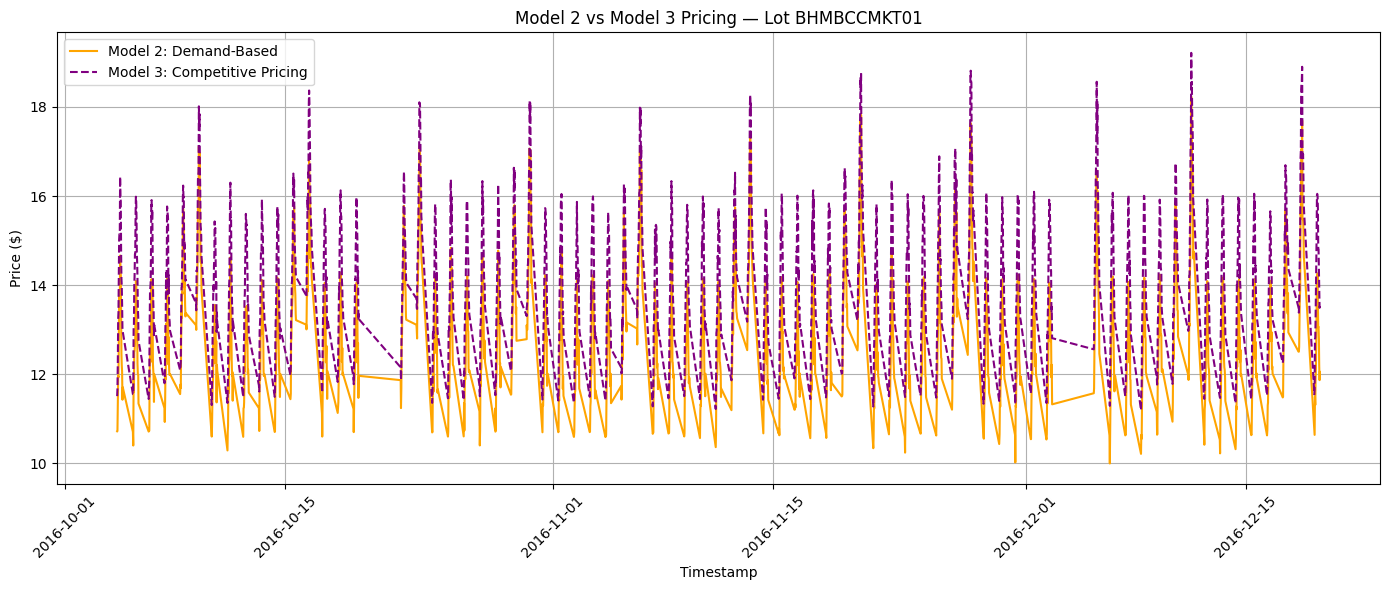

In [160]:
# Model2Price vs Model3Price
import matplotlib.pyplot as plt

# Pick parking lot
sample_lot = df_model2['SystemCodeNumber'].unique()[0]
lot_data = df_model2[df_model2['SystemCodeNumber'] == sample_lot]

plt.figure(figsize=(14, 6))
plt.plot(lot_data['Timestamp'], lot_data['Model2Price'], label='Model 2: Demand-Based', color='orange')
plt.plot(lot_data['Timestamp'], lot_data['Model3Price'], label='Model 3: Competitive Pricing', color='purple', linestyle='--')

plt.title(f"Model 2 vs Model 3 Pricing — Lot {sample_lot}")
plt.xlabel("Timestamp")
plt.ylabel("Price ($)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [161]:
import pandas as pd
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource

output_notebook()

sample_lot = df_model2['SystemCodeNumber'].unique()[0]
lot_data = df_model2[df_model2['SystemCodeNumber'] == sample_lot].copy()

lot_data['Timestamp'] = pd.to_datetime(lot_data['Timestamp'])

source = ColumnDataSource(lot_data)

p = figure(x_axis_type="datetime", title=f"Model 2 vs Model 3 Pricing — Lot {sample_lot}", width=1000, height=400)

p.line(x='Timestamp', y='Model2Price', source=source, color='orange', line_width=2, legend_label='Model 2 Price')

p.line(x='Timestamp', y='Model3Price', source=source, color='purple', line_width=2, line_dash='dashed', legend_label='Model 3 Price')

p.xaxis.axis_label = "Time"
p.yaxis.axis_label = "Price ($)"
p.legend.location = "top_left"
p.legend.click_policy = "hide"
p.grid.grid_line_alpha = 0.3

show(p)

Loading BokehJS ...

In [162]:
#CSV Exporting 
model3_export = df_model2[[
    'SystemCodeNumber', 'Timestamp', 'Occupancy', 'Capacity',
    'Model1Price' if 'Model1Price' in df_model2.columns else 'BaselinePrice',
    'Model2Price', 'Model3Price', 'Model3Revenue',
    'NearbyAvgPrice', 'NearbyAvgOccupancyRatio'
]]

model3_export.to_csv("model3_Competitive_Pricing_Model_output.csv", index=False)

## Price vs Occupancy Plot for Model 3

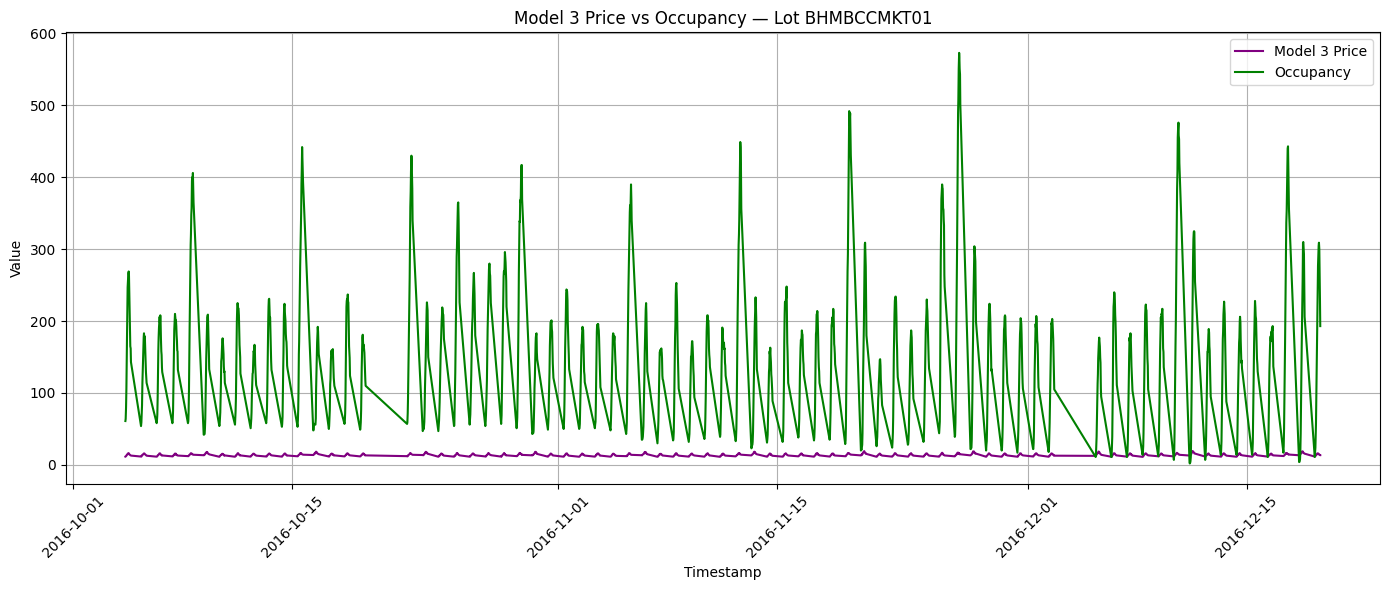

In [163]:
plt.figure(figsize=(14, 6))
plt.plot(lot_data['Timestamp'], lot_data['Model3Price'], label='Model 3 Price', color='purple')
plt.plot(lot_data['Timestamp'], lot_data['Occupancy'], label='Occupancy', color='green')

plt.title(f"Model 3 Price vs Occupancy — Lot {sample_lot}")
plt.xlabel("Timestamp")
plt.xticks(rotation=45)
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Model 3: Competitive Pricing

---

### Objective

To enhance the dynamic pricing strategy by making it location-aware and competitor-sensitive. This model adjusts parking prices in real time based on the prices and occupancy levels of nearby lots, simulating real-world business competition.

---

### Core Idea

> “Don’t just respond to your own demand adapt your price based on what your neighbors are doing.”

---

### Key Concepts

| Feature                   | Description                                      |
| ------------------------- | ------------------------------------------------ |
| `Latitude & Longitude`    | Used to find nearby parking lots                 |
| `NearbyAvgPrice`          | Average Model 2 price of competitors within 2 km |
| `NearbyAvgOccupancyRatio` | Avg occupancy ratio (demand) of nearby lots      |
| `Model2Price`             | Price based on demand from Model 2               |

---

### Competitive Pricing Logic

The final Model 3 price is calculated as:

$$
\text{Model3Price} = 0.6 \cdot \text{Model2Price} + 0.4 \cdot \text{NearbyAvgPrice} + \beta \cdot \text{NearbyAvgOccupancyRatio}
$$

* **β = 2.0** (tunable weight for competitor occupancy pressure)
* Final price is **clipped between \$5 \ and \$20**

---

### Interpretation

| Situation                             | Pricing Behavior                               |
| ------------------------------------- | -----------------------------------------------|
| Nearby lots are full + expensive      | Raise price — stay competitive yet profitable |
| Nearby lots are empty + cheap         | Lower price — attract demand or reroute       |
| Your lot is empty but others are full | Moderate — follow competitor trend            |

---

### Features Engineered

| Feature                         | Column                                    |
| ------------------------------- | ----------------------------------------- |
| Distance-based neighbor mapping | `neighbor_dict`                           |
| Nearby average price            | `NearbyAvgPrice`                          |
| Nearby average demand           | `NearbyAvgOccupancyRatio`                 |
| Final competitive price         | `Model3Price`                             |
| Revenue estimate                | `Model3Revenue = Model3Price × Occupancy` |

---

### Visualizations

* Model 2 vs Model 3 price trends (Matplotlib & Bokeh)
* Price vs Occupancy patterns
* Location-driven pricing behavior

---

### Key Advantages

* **Simulates market competition**
* Uses **geospatial intelligence** for dynamic pricing
* Adds **business logic** and real-world adaptability
* Avoids overpricing or underpricing in a dense parking network

---

## Summary: Model 1 vs Model 2 vs Model 3

| Feature / Behavior                      | Model 1: Baseline Linear | Model 2: Demand-Based                                                   | Model 3: Competitive Pricing                        |
| --------------------------------------- | ------------------------ | ----------------------------------------------------------------------- | --------------------------------------------------- |
| **Inputs Used**                         | Occupancy                | Occupancy, Queue, Traffic, SpecialDay, VehicleType, Weekend, OfficeHour | All Model 2 inputs + Nearby lots (price, occupancy) |
| **Time-Aware?**                         |  No                     |  Yes (office hours, weekend)                                           |  Yes                                               |
| **Location-Aware?**                     |  No                     |  No                                                                    |  Yes (lat-long neighbors)                          |
| **Price Adjusts with Local Demand?**    |  Basic (linearly)       |  Smartly                                                               |  Smart + competitive                               |
| **Price Influenced by Competitors?**    |  No                     |  No                                                                    |  Yes                                               |
| **Complexity Level**                    | ⭐ (Simple)               | ⭐⭐⭐ (Intermediate)                                                      | ⭐⭐⭐⭐ (Advanced, realistic)                          |
| **Revenue Estimation**                  | Yes                        | Yes                                                                     | Yes                                                  |
| **Adaptability to Real-World Use Case** | Limited                | Strong                                                                | Excellent (market-driven)                         |

---

# Real-Time Simulation with Pathway

In [164]:
#!pip install -U pathway # Works on Google Colab Only 